## Estimating the correlation scale and Taylor scale
*Demonstrating the calculation of numerically-derived variables in the Wind database*

As well as raw variables such as electron density and magnetic field strength, and analytically-derived variables such as Alfven speed and ion gyroradius, the *Wind* database contains numerically-derived ("estimated") variables. The two parameters we are most interested are the *correlation scale* and *Taylor scale*. Both scales are calculated from the autocorrelation function, and both require some thought as to what technique to use to calculate them.

### Notes
- The interval used to demonstrate the pipeline is not ideal in that its ACF lacks the desired parabolic shape near the origin and overall exponential shape. However, it is still a useful demonstration given that not all ACFs will have this nice shape.
- Scales are returned in units of seconds
- For demonstration purposes, `plot=True` arguments in functions assume a solar wind speed of 400km/s. The specific speeds measured for each interval are used in the actual analysis. 
- We expect slight variation from Kevin's numbers due to using a cadence of 11Hz instead of 10Hz.

In [1193]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import importlib

#import os
# while ".toplevel" not in os.listdir():
#     os.chdir("..")

import src.utils as utils
import src.params as params

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "omni_path": params.omni_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,

    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "omni_vars": [params.timestamp, params.vsw, params.p, params.Bomni],
    "proton_vars": [params.timestamp, params.ni, params.Ti],
    "electron_vars": [params.timestamp, params.ne, params.Te],

    # arg3
    "mag_thresh": params.mag_thresh,
    "omni_thresh": params.omni_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,

    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,

    # arg5
    "dt_lr": params.dt_lr
}

In [1194]:
# Set fontsize of plots
plt.rcParams.update({'font.size': 12})
#import matplotlib
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [1195]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

In a bash terminal, run `bash 0_download_files.sh`, followed by `bash 1_get_raw_vars.sh`. (For some reason `%%bash` command in a Jupyter cell isn't working)

## Calculating numerically-derived variables

### 11Hz data

In [1196]:
file = "data/raw/wind/mfi/mfi_h2/2016/wi_h2_mfi_20160102_v05.cdf"
timestamp = "2016-01-02 12:00:00"

In [1197]:
df = utils.pipeline(
    file,
    varlist=sys_arg_dict["mag_vars"],
    thresholds=sys_arg_dict["mag_thresh"],
    cadence=sys_arg_dict["dt_hr"]
)
#print("Reading {0}: {1:.2f}% missing".format(file, df.iloc[:,0].isna().sum()/len(df)*100))

# Ensuring observations are in chronological order
df_wind_hr = df.sort_index()

KeyboardInterrupt: 

In [ ]:
#df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
df_wind_hr = df_wind_hr.rename(
    columns={
        params.Bwind:'Bwind',
        params.Bx:'Bx',
        params.By:'By',
        params.Bz:'Bz'})

df_wind_hr.shape

(939131, 4)

Extracting a single 12-hour interval to demonstrate the pipeline. *The timestamp "00:00" refers to data betweeen 00:00 and 12:00.*

In [ ]:
int_wind_hr = df_wind_hr[pd.to_datetime(timestamp):pd.to_datetime(timestamp)+pd.to_timedelta("12H")]
int_wind_hr.shape

(469565, 4)

In [ ]:
int_wind_hr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469565 entries, 2016-01-02 12:00:00.072000 to 2016-01-02 23:59:59.960000
Freq: 92L
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Bwind   459891 non-null  float32
 1   Bx      459891 non-null  float32
 2   By      459891 non-null  float32
 3   Bz      459891 non-null  float32
dtypes: float32(4)
memory usage: 10.7 MB


In [ ]:
int_wind_hr.isna().sum()

Bwind    9674
Bx       9674
By       9674
Bz       9674
dtype: int64

### 0.2Hz data

In [ ]:
#df_wind_lr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_lr + ".pkl")
# df_wind_lr = df_wind_lr.rename(
#     columns={
#         params.Bwind:'Bwind',
#         params.Bx:'Bx',
#         params.By:'By',
#         params.Bz:'Bz'})

df_wind_lr = df_wind_hr.resample("5S").mean()
df_wind_lr.shape

(17280, 4)

Extracting a single 12-hour interval to demonstrate the pipeline

In [ ]:
int_wind_lr = df_wind_lr[pd.to_datetime(timestamp):pd.to_datetime(timestamp)+pd.to_timedelta("12H")]
int_wind_lr.shape

(8640, 4)

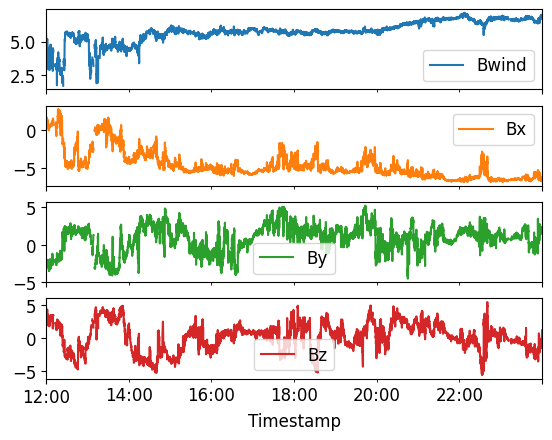

In [ ]:
int_wind_lr.plot(subplots=True)
plt.show()

In [ ]:
missing =  int_wind_hr.iloc[:,0].isna().sum()/len(int_wind_hr)
print(missing)

if missing > 0.4:
    # Replacing values in lists with na
    print("Large missing %")
else:
    int_wind_hr = int_wind_hr.interpolate().ffill().bfill()
    int_wind_lr = int_wind_lr.interpolate().ffill().bfill()

0.020602046575021564


In [ ]:
int_wind_hr.isna().sum()

Bwind    0
Bx       0
By       0
Bz       0
dtype: int64

In [ ]:
int_wind_lr.isna().sum()

Bwind    0
Bx       0
By       0
Bz       0
dtype: int64

In [ ]:
# Takes ~ 5min

#int_wind_hr.plot(subplots=True)
#plt.show()

In order to fully implement Chuychai's method, we need the spectral index (slope) of the power law in the dissipation range. Here we compute a smoothed 3D periodogram for a single high-res interval, then perform a least squares fit of a power law to the inertial and kinetic ranges to determine their slopes and the spectral break.

**Maths for calculating breakpoint:**

Each power-law fit is given by the following equation:

$$y =x^me^c$$

This is because if we take the log of both sides, we get the formula for a straight line on a log-log plot:

$$\log(y) = m\log(x)+c$$

We want to find the x-value for which the two power-laws are equal. We can do this by subtracting one from the other and finding the value of $\log(x)$ where this subtraction = 0, i.e., the root of the equation.

$$m_1\log(x)+c_1-m_2\log(x)-c_2=0$$

Finally, we take the exponential of this root to get the x-value of the spectral break

$$x = e^{\log(x)}$$

In [ ]:
# Reading in dataframe to get values for qi, di, etc.
df = pd.read_csv("wind_omni_dataset.csv", index_col="Timestamp")
df.index = pd.to_datetime(df.index)

In [ ]:
df[['Re_lt', 'Re_tb', 'Re_di']].describe()

,Re_lt,Re_tb,Re_di
count,1.950600e+04,1.820600e+04,1.907700e+04
mean,4.522910e+06,6.614888e+04,1.940325e+05
std,2.918859e+08,1.023698e+05,2.095532e+05
min,2.977838e+02,1.738250e-01,4.041764e+02
25%,3.014250e+04,1.600254e+04,7.041514e+04
50%,6.815865e+04,3.462614e+04,1.291935e+05
75%,1.636965e+05,7.389633e+04,2.397069e+05
max,3.434170e+10,1.838851e+06,2.886971e+06


In [ ]:
df[['Re_lt', 'Re_tb', 'Re_di']].corr('pearson')

,Re_lt,Re_tb,Re_di
Re_lt,1.000000,0.030674,0.008356
Re_tb,0.030674,1.000000,0.692389
Re_di,0.008356,0.692389,1.000000


In [ ]:
df[['Re_lt', 'Re_tb', 'Re_di']].corr('spearman')

,Re_lt,Re_tb,Re_di
Re_lt,1.000000,0.459801,0.663462
Re_tb,0.459801,1.000000,0.689848
Re_di,0.663462,0.689848,1.000000


In [ ]:
importlib.reload(utils)
importlib.reload(params)

<module 'src.params' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\params.py'>

The following requires specification of the inertial and kinetic ranges. I have used the values used previously in the literature for Wind spectral analysis. Sometimes we cannot get a good intersection between the two for a spectral break.

In [ ]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

(-1.740423114261999, -3.026077172159704, 0.20382611339664775)

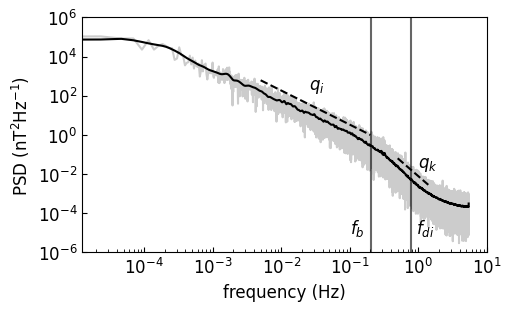

In [ ]:
z_i, z_k, spectral_break, fig, ax, f_periodogram, p_smooth = utils.compute_spectral_stats(
    np.array([int_wind_hr.Bx, int_wind_hr.By, int_wind_hr.Bz]), 
    dt=float(params.dt_hr[:-1]),
    f_min_inertial=params.f_min_inertial, f_max_inertial=params.f_max_inertial,
    f_min_kinetic=params.f_min_kinetic, f_max_kinetic=params.f_max_kinetic,
    di = df.loc[timestamp, "di"],
    velocity = df.loc[timestamp, "vsw"],
    plot=True)

z_i, z_k, spectral_break

In [ ]:
fig.savefig("plots/final/psd.pdf")

Additional figure with power spectra shifted up and down, demonstrating how Taylor scale captures different energies, unlike other Re formulations


[]

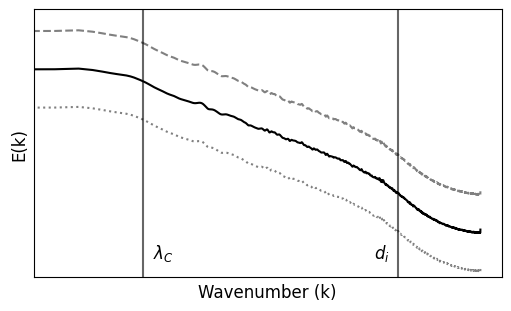

In [ ]:
fig, ax = plt.subplots(figsize = (5,3), constrained_layout=True)
ax.set_ylim(1e-6, 1e8)
#ax.set_xlim(f_periodogram[0], 1e0)

ax.semilogy(f_periodogram, p_smooth, color = "black")
ax.semilogy(f_periodogram, p_smooth*100, ls = '--', color = "gray")
ax.semilogy(f_periodogram, p_smooth/100, ls = 'dotted', color = "gray")
ax.semilogx()
ax.set_xlabel("Wavenumber (k)")
ax.set_ylabel("E(k)")
ax.axvline(3e-4, label = "$\lambda_C$", color='black', alpha = 0.6)
ax.axvline(5e-1, label = "$\lambda_d$", color='black', alpha = 0.6)
ax.text(4e-4, 1e-5, "$\lambda_C$")
ax.text(2.5e-1, 1e-5, "$d_i$")
ax.set_xticks([])
ax.set_xticks([], minor=True)
ax.set_yticks([])

In [ ]:
fig.savefig("plots/final/shifted_spectra.pdf")

- $\alpha_{i}=-1.66$
- $\alpha_{k}=-2.4$
- $f_d=0.26$ Hz (dissipation scale)
- $\tau_d=1/f_d=1/0.26=3.8$

Chuychai et al. recommend that the resolution of the data be at least as good as $\Delta t <0.4\tau_d$. We later find the mean value of $\tau_d$ to be $1/0.25=4$. Using this value, we see our resolution is sufficient:

- $1/11 = 0.091$
- $0.4\times4=1.6$
- $0.091 < 1.6$

<u>We need to justify the frequency bounds we have specified for fitting the power law slopes.</u>
See e.g. *The kinetic range is usually above the spacecraft frame frequency corresponding to the proton inertial length, $f_{pi}=v_{SW}/(2\pi\lambda_{pi}$)* (from Pitna et al. (2021), quantities plotted as vertical lines above).

### ACF function

This is what we use to calculate the correlation scale and Taylor scale. Note that Chuychai et al. did not calculate the ACF directly from the data; they calculated it from the second-order structure function. Here, we will calculate it directly from the data.

The following function is based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. It automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows:

$$R(\tau)=\frac{1}{3}\times(R_{xx}(\tau)+R_{yy}(\tau)+R_{zz}(\tau))$$

The following low-cadence, high $r$ ACF will be used for calculating the outer scale.

In [ ]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

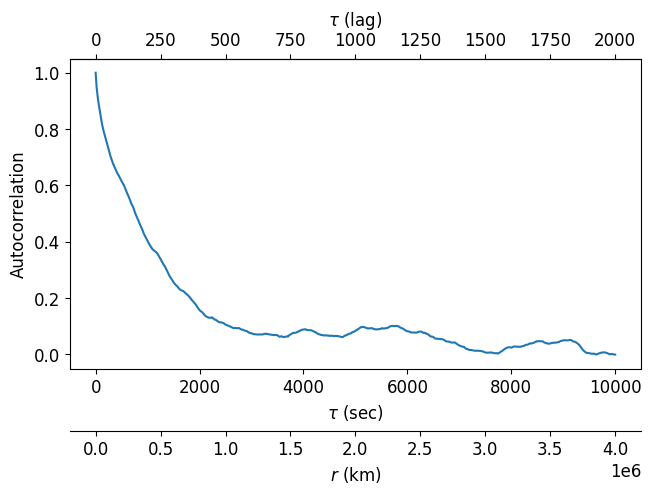

In [ ]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    np.array(
        [int_wind_lr.Bx, int_wind_lr.By, int_wind_lr.Bz]), 
        nlags=params.nlags_lr, 
        dt=float(params.dt_lr[:-1]), # Removing "S" from end 
        plot=True
    )

The following high-cadence, low $r$ ACF will be used for calculating the Taylor scale.

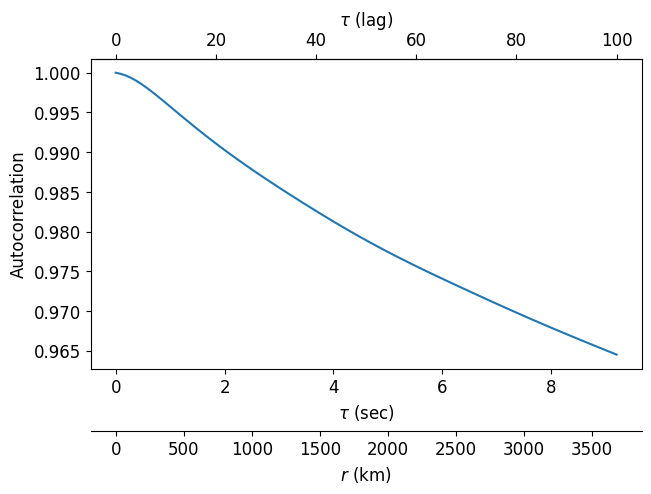

In [ ]:
time_lags_hr, r_vec_hr = utils.compute_nd_acf(
    np.array([
            int_wind_hr.Bx, 
            int_wind_hr.By, 
            int_wind_hr.Bz
            ]), 
        nlags=params.nlags_hr, 
        dt = float(params.dt_hr[:-1]), # Removing "S" from end 
        plot = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Methods for calculating:
- 1/e trick
- Exponential fit
- Integration

Smith et al. (2001) used the 1/e trick method (which they call $e$-folding) and the integration method. In Appendix B of their paper, they show how the estimates by either method increase depending on the lag up to which you calculate the ACF.

Firstly, using Kevin's function (just with plotting functionality added) for computing outer scale using $1/e$ trick:

**If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.**

Kevin referred to the value calculated from this method in his analysis as `estimate` and `Correlation_timescale_est`.

In [1200]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

1129.727

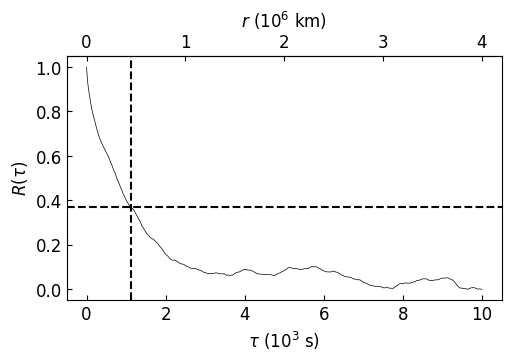

In [1201]:
tce, fig, ax = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot = True)
tce

What values should we expect? The lit review spreadsheet shows values in the range of $\lambda_C=$ 320,000 - 1,200,000km.

Secondly, adapting Kevin's function for computing outer scale using exponential fit, from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$


Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

<u>How to choose how much of the ACF to fit to?</u> Kevin used 1000 seconds, which was decided "through some trial and error and inspection of plotted results". While we should keep in mind that the correlation length will tend to increase with the maximum lag we fit to, I think we should fit to much more than 1000 seconds, as in the literature we see typical fits to 1-3,000,000km, corresponding to 2500-7500 seconds or 500-1500 lags. **We are now fitting to 2 times the correlation timescale, as estimated by the 1/e method.**

**Fit to 2 * 1/e estimate**

In [1202]:
tcf, fig, ax = utils.compute_outer_scale_exp_fit(time_lags=time_lags_lr, acf=r_vec_lr, seconds_to_fit=np.round(2*tce), fig = fig, ax = ax, plot = True)
tcf

1085.4295087027403

Finally, creating a function for computing outer scale as integral of the ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970). 

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [1203]:
tci, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig=fig, ax=ax, plot = True)
tci

1380.5474687085905

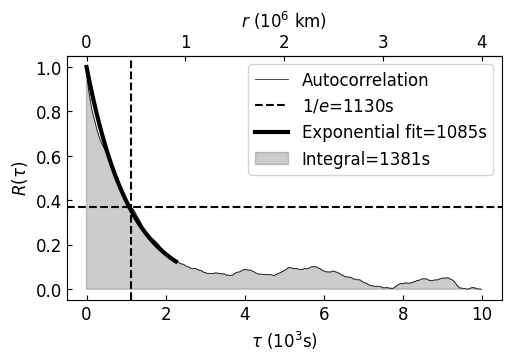

In [1204]:
fig

In [1205]:
fig.savefig('plots/final/corr_scale_methods.pdf')

Isaacs et al. (2015) looked at the effect of **interval size** on the estimate of the correlation length, using data from ACE and comparing against the "true", multi-spacecraft value. The plots below line up quite well with the values calculated from our 6-hour intervals. In the accompanying discussion on pg10 of the paper, they state "averaging intervals of 10-20 hours appear to have a special significance with regard to computation of correlation scales."


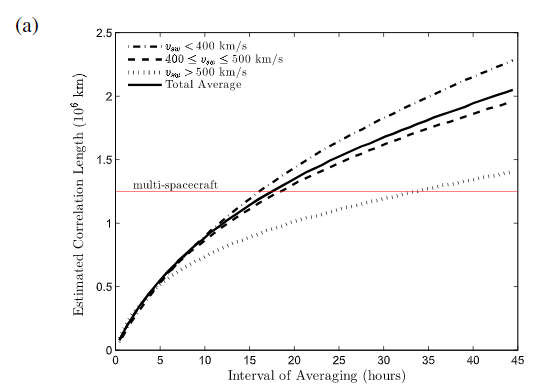

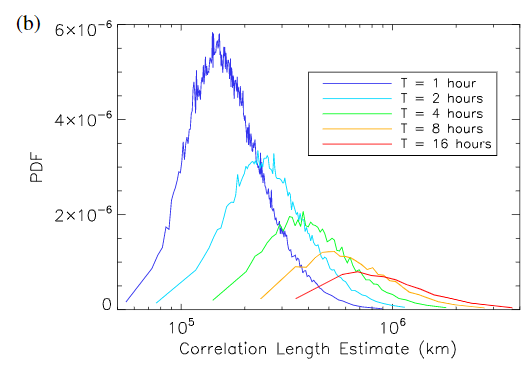

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This code is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [1152]:
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\reynolds_scales_project\\src\\utils.py'>

c:\Users\spann\Documents\Research\Code repos\reynolds_scales_project\src\utils.py:517: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-y" (-> color='y'). The keyword argument will take precedence.
  ax[0].plot(


15.771723433957858

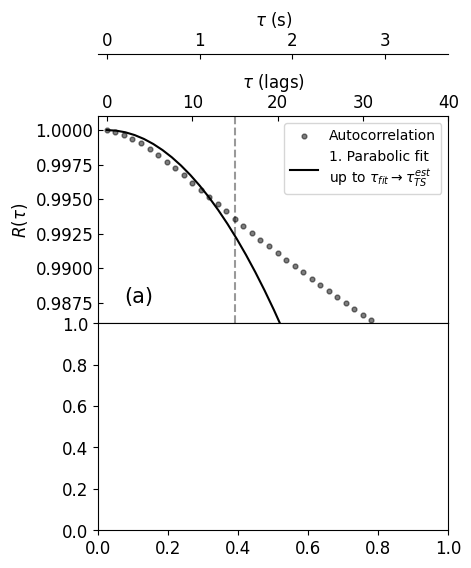

In [1153]:
lambda_t, fig, ax = utils.compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=15, plot = True, show_intercept=False)
lambda_t
# Set show_intercept = True if you want piece of mind that the value returned is actually the x-intercept

#### Chuychai (Richardson) extrapolation method

We can't just use the above function for some very small lag close to the origin, because as noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resolution and there may be limited data available at the shortest time lags". Therefore, we can calculate the Taylor scale from a parabolic fit for a *range* of values of $\tau_{fit}$, up to $\tau_{max}$. Plot these values as a function of $\tau_{fit}$, then draw a straight line through the points back to $\tau_{fit}=0$. 

See lit review spreadsheet for ranges of $\tau_{fit}$ in other studies.

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{TS}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $\tau_{TS}$: final estimate after applying correction factor
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

<u>How do we choose the upper value, $\tau_{max}$?</u> This is investigated in Fig. 5 of Chuychai. Weygand et al. (2007) show an example of reaching a stable estimate as $\tau_{max}$ increases, but Chuychai shows that this is dependent on the spectral index. In particular, they note that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

**Here we have decided to set $\tau_{min}$ = 10 lags $\approx 1s $ and $\tau_{max}$= 50 lags $\approx 5s$.** This is roughly in line with what Chuychai & Matthaeus did for ACE data, while reducing $\tau_{max}$ due to understanding that we will not get convergence with increasing $\tau_{max}$ due to the relatively shallow values of $q$. This also matches their recommendation that a good estimate is obtained by an extrapolation of the curves evaluated near $\tau_{max}=\tau_d=4s$.

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess". The equation for this final estimate is given in Eq. 10 of the paper, and is coded into the following function.

We can compare the following to Fig. 4 in Chuychai, and less directly to Figs. 5 and 7 in Weygand et al. (2007)

In [1154]:
# Not applying Chuychai correction factor
ts_est_extra, ts_est_extra_std = utils.compute_taylor_chuychai(
    time_lags_hr, 
    r_vec_hr, 
    tau_min=params.tau_min, 
    tau_max=params.tau_max)
ts_est_extra

10.620638938079269

In [1155]:
# Applying Chuychai correction factor
ts_est, ts_est_std, fig, ax = utils.compute_taylor_chuychai(
    time_lags_hr, 
    r_vec_hr, 
    tau_min=params.tau_min, 
    tau_max=params.tau_max, 
    q = df.loc[timestamp, "qk"], 
    tau_fit_single=15,
    fig=fig,
    ax=ax)
print(ts_est, ts_est_std)

8.894755491712326 0.04590859183048431


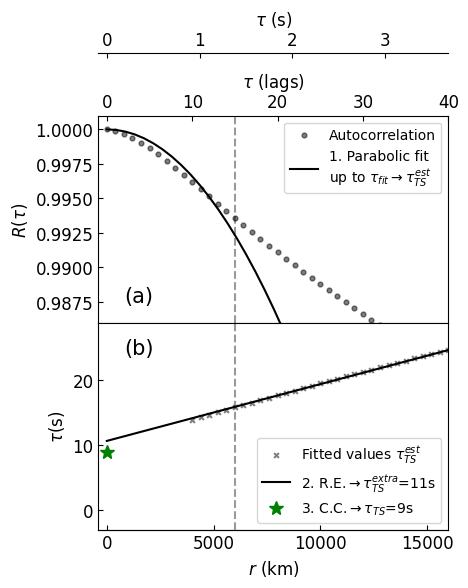

In [1156]:
fig

In [1157]:
fig.savefig("plots/final/taylor_scale_2_panel.pdf")

In [1158]:
# Meta-analysis: dependence on t_max. Takes ~ 4min to run

# tau_max_lower = 20
# tau_max_upper = 1000

# tau_fit_max = np.arange(tau_max_lower, tau_max_upper +1)
# tau_ts_meta = np.array([])

# for i in tau_fit_max:
#     ts_est_final = compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=10, tau_max=i, q = -2.14, show = False)
#     tau_ts_meta = np.append(tau_ts_meta, ts_est_final)

# plt.plot(tau_fit_max, tau_ts_meta)
# plt.xlabel("$\\tau_{max}$")
# plt.ylabel("$\\tau_{final}$")
# plt.show()

These settings can be investigated by looking at the output plots of the `calculate_numerical_vars.py` script. These show the ACFs and fits for the min, median and max correlation scale (exp method) and Taylor scale.